In [3]:
import matplotlib.pyplot as plt
from matplotlib import image
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd
import cv2
import os
from BfTableGenerator import TDmapLoader
from tqdm import tqdm
from Utils import *
from open3d.web_visualizer import draw
from joblib import Parallel, delayed
from VisulizerTools import *
from DDBSCAN import Raster_DBSCAN
from sklearn.cluster import DBSCAN
import time
plt.rcParams["font.family"] = "Times New Roman"
from GeoRefTool import *
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.data import stereo_motorcycle, vortex
from skimage.transform import warp
from skimage.registration import optical_flow_tvl1, optical_flow_ilk
from BfTableGenerator import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [4]:
def count(TSAv):
    temp_count = 0
    apear_ind = []
    counts = []
    for i in range(len(TSAv)):
        if (TSAv[i] == True):
            temp_count += 1
        else:
            if (i > 0) & (TSAv[i - 1] == True):
                apear_ind.append(i - temp_count)
                counts.append(temp_count)
                temp_count = 0
                counts.append(0)
            else:
                counts.append(0)
        if (i == len(TSAv) - 1) & (temp_count != 0):
            apear_ind.append(i - temp_count + 1)
            counts.append(temp_count)
    counts = np.array(counts)
    counts = counts[counts > 0]
    return np.array(counts), np.array(apear_ind)

In [5]:
def gen_xyz(dis,i,j):
    longitudes = theta[i]*np.pi / 180
    latitudes = azimuths[j] * np.pi / 180 
    hypotenuses = dis * np.cos(longitudes)
    X = hypotenuses * np.sin(latitudes)
    Y = hypotenuses * np.cos(latitudes)
    Z = dis * np.sin(longitudes)
    return np.array([X,Y,Z])

In [38]:
db = Raster_DBSCAN(window_size=[5,13],eps = 1.5,min_samples = 12,Td_map_szie = [32,1800])
dbscan = DBSCAN(eps = 1, min_samples = 20)

In [6]:
thred_map = np.load(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\DATA\bck_larue.npy')


In [7]:
aggregated_map = []
Inten_maps = []
pcap_path = r'D:\LiDAR_Data\MidTown\Larue\PaperPcaps\2022-1-22-11-0-0.pcap'
end_frame = 18000
lidar_reader = TDmapLoader(pcap_path)
frame_gen = lidar_reader.frame_gen()
for i in tqdm(range(end_frame)):
    Frame = next(frame_gen)
    if Frame is None:
        break 
    Td_map,Int_map = Frame
    aggregated_map.append(Td_map)
    Inten_maps.append(Int_map)
aggregated_map = np.array(aggregated_map)
Inten_maps = np.array(Inten_maps)
# thred_map = gen_bckmap(aggregated_map, N = 10,d_thred = 0.08,bck_n = 3 )
thred_map = np.load(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\DATA\bck_larue.npy')
thred_map = thred_map.max(axis = 0)
aggregated_Labeling_map = []
for i in tqdm(range(aggregated_map.shape[0])):
    Td_map = aggregated_map[i]
    Foreground_map = ~(np.abs(Td_map - thred_map) <= 1.5).any(axis = 0)
    Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
    aggregated_Labeling_map.append(Labeling_map)
aggregated_Labeling_map = np.array(aggregated_Labeling_map)
points = []
occupancies = []
row_ind = []
col_ind = []
for i in tqdm(range(32)):
    for j in range(1800):
        foreground_ind = aggregated_Labeling_map[:,i,j] != -1
        if foreground_ind.any(): # foreground
            dis_values = aggregated_map[foreground_ind,i,j]
            labels = dbscan.fit_predict(dis_values.reshape(-1,1))
            unique_labels = np.unique(labels)
            unique_labels = unique_labels[1:]
            if len(unique_labels) >= 1: 
                for l in unique_labels:
                    dis = np.mean(dis_values[labels == l])
                    XYZ = gen_xyz(dis,i,j)
                    points.append(XYZ)
                    occupancy = (labels == l).sum()/len(foreground_ind)
                    occupancies.append(occupancy)
                    row_ind.append(i)
                    col_ind.append(j)
points = np.array(points)
occupancies = np.array(occupancies)
col_ind = np.array(col_ind)
row_ind = np.array(row_ind)
pcd = get_pcd_uncolored(aggregated_map[1354])
plane_model, inliers = pcd.segment_plane(distance_threshold=0.3,
                                         ransac_n=10,
                                         num_iterations=1000)
height = np.abs(plane_model[0] * points[:,0] + plane_model[1] * points[:,1] + plane_model[2] * points[:,2] + plane_model[3]) / (np.sqrt(plane_model[0]**2 + plane_model[1]**2 +plane_model[2]**2))
input_path = r'D:\LiDAR_Data\MidTown\Larue\Calibration'
ref_LLH_path,ref_xyz_path = os.path.join(input_path,'LLE_ref.csv'),os.path.join(input_path,'xyz_ref.csv')
ref_LLH,ref_xyz = np.array(pd.read_csv(ref_LLH_path)),np.array(pd.read_csv(ref_xyz_path))
if len(np.unique(ref_xyz[:,2])) == 1:
    np.random.seed(1)
    offset = np.random.normal(-0.521,3.28,len(ref_LLH))
    ref_xyz[:,2] += offset
    ref_LLH[:,2] += offset * 3.2808
ref_LLH[:,[0,1]] = ref_LLH[:,[0,1]] * np.pi/180
ref_LLH[:,2] = ref_LLH[:,2]/3.2808

T = generate_T(ref_LLH,ref_xyz)
LLH = convert_LLH(points.astype(np.float64),T)
resultGram = pd.DataFrame(np.concatenate([points,LLH,occupancies.reshape(-1,1),height.reshape(-1,1),row_ind.reshape(-1,1),col_ind.reshape(-1,1)],axis =1 ),columns=['X','Y','Z','Longitude','Latitude','Elevation','Occupancy','Height','LaserID','AzimuthID'])
resultGram.to_csv(r'D:\LiDAR_Data\MidTown\Larue\occ.csv',index = False)

  0%|                                                                                        | 0/17847 [00:00<?, ?it/s]


ValueError: not enough values to unpack (expected 2, got 1)

In [9]:
Foreground_map

array([False, False, False, ..., False, False, False])

24.884
1309


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

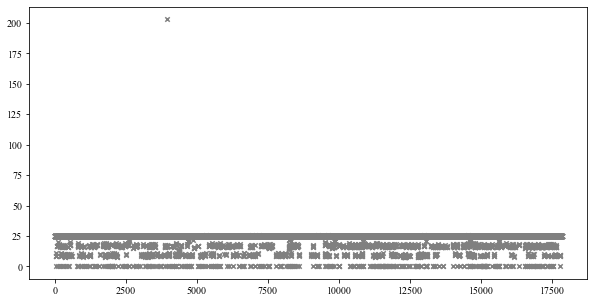

In [12]:
laser_id = 4
azimuth_channel = 1309
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
for i in range(len(thred)):
    plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
plt.ylim(0,70)

# plt.xlim(2000,2400)
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\parameterdefinition.tif', dpi = 600)
plt.show()

## Large Bck Generator

In [1]:
def get_thred(temp,N = 10,d_thred = 0.1,bck_n = 3):
    temp = temp.copy()
    total_sample = len(temp)
    bck_ds = []
    bck_portions = []
    repeat = 0
    while repeat < N:
        if len(temp) == 0:
            break
        sample = np.random.choice(temp,replace=False)
        ind = np.abs(temp - sample) < 0.3
        portion = ind.sum()/total_sample
        if portion > d_thred:
            bck_portions.append(portion)
            bck_ds.append(sample)
            temp = temp[~ind]
        repeat += 1
        
    bck_ds = np.array(bck_ds)
    bck_portions = np.array(bck_portions)
    arg_ind = np.argsort(bck_portions)[::-1]
    bck_ds_ = bck_ds[arg_ind[:bck_n]]
    
    if len(bck_ds_) <= bck_n:
        bck_ds_ = np.concatenate([bck_ds_,-1 * np.ones(bck_n - len(bck_ds_))])
    return bck_ds_

In [2]:
def gen_bckmap(aggregated_maps, N, d_thred, bck_n):
    thred_map = np.zeros((bck_n,32,1800))
    for i in tqdm(range(thred_map.shape[1])):
        for j in range(thred_map.shape[2]):
            thred_map[:,i,j] = get_thred(aggregated_maps[:,i,j],N = N,d_thred = d_thred,bck_n = bck_n)
    return thred_map

In [7]:
f_path = r'D:\LiDAR_Data\MidTown\Larue\Agg'
agg_dirs = np.array(os.listdir(f_path))
hours = [eval(f.split('-')[3]) for f in agg_dirs]
agg_dirs = agg_dirs[np.argsort(hours)]

In [8]:
aggregated_maps = []
for f in tqdm(agg_dirs):
    aggregated_map = np.load(os.path.join(f_path,f))
    aggregated_maps.append(aggregated_map)
aggregated_maps = np.concatenate(aggregated_maps)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [02:44<00:00,  6.85s/it]


In [17]:
thred_map = gen_bckmap(aggregated_maps, N = 20,d_thred = 0.12,bck_n = 5)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [04:26<00:00,  8.34s/it]


In [18]:
np.save(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\DATA\bck_larue.npy',thred_map)

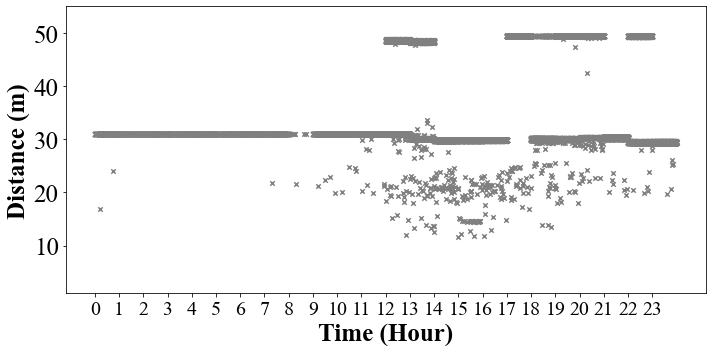

In [18]:
laser_id = 13
azimuth_channel = 539
temp = aggregated_maps[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
# for i in range(len(thred)):
#     plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.yticks(fontsize = 25)
plt.xticks(np.arange(0,48000,2000), np.arange(24),fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (Hour)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
plt.ylim(1,55)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\FIG\OnedayBands.tif',dpi = 300)
plt.show()

## Parking Test

In [6]:
thred_map = np.load(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\DATA\bck_larue.npy')

In [8]:
aggregated_map = []
Inten_maps = []
pcap_path = r'D:\LiDAR_Data\MidTown\Larue\PaperPcaps\2022-1-22-13-0-0.pcap'
end_frame = 18000
lidar_reader = TDmapLoader(pcap_path)
frame_gen = lidar_reader.frame_gen()
for i in tqdm(range(end_frame)):
    Frame = next(frame_gen)
    if Frame is None:
        break 
    Td_map,Int_map = Frame
    aggregated_map.append(Td_map)
    Inten_maps.append(Int_map)
aggregated_map = np.array(aggregated_map)

100%|████████████████████████████████████████████████████████████████████████████| 18000/18000 [11:51<00:00, 25.30it/s]


In [9]:
Parking_coord = np.array([[15,496],[11,537],[13,556]])

In [14]:
row_ind,col_ind = [],[]
occupancies = []
starts = []
ends = []
points = []
i = 15
j = 496

temp = aggregated_map[:,i,j].copy()
thred = thred_map[:,i,j]
thred_max = thred.max()
bck_inds = ((np.abs((temp - thred_max)) < 2))
temp[bck_inds] = 0
time_window = 600
parking_label  = []
for i in range(time_window,len(temp)):
    past_dis = temp[i - time_window:i]
    past_dis = past_dis[past_dis!=0]
    if len(past_dis) == 0:
        parking_label.append(False)
    else:
        if np.abs(temp[i] - np.median(past_dis)) < 0.6:
            parking_label.append(True)
        else:
            parking_label.append(False)
parking_label = time_window*[parking_label[0]] + parking_label
parking_label = np.array(parking_label)
counts,appears = count(~parking_label)
for i,a in enumerate(appears):
    c = counts[i]
    if c < time_window:
        parking_label[a:a+c+1] = True
counts,appears = count(parking_label)
for i,a in enumerate(appears):
    c = counts[i]
    if c < time_window:
        parking_label[a:a+c+1] = False
counts,appears = count(parking_label) 

for l,a in enumerate(appears):
    parking_dis = temp[a:a+counts[l]]
    parking_dis = parking_dis[parking_dis!=0]
    dis =  np.median(parking_dis)
    XYZ = gen_xyz(dis,i,j)
    points.append(XYZ)
    occupancy = counts[l]
    occupancies.append(occupancy)
    row_ind.append(i)
    col_ind.append(j)
    starts.append(a)
    ends.append(a + counts[l])
    
points = np.array(points)
occupancies = np.array(occupancies)
col_ind = np.array(col_ind)
row_ind = np.array(row_ind)
starts = np.array(starts)
ends = np.array(ends)

# LLH = convert_LLH(points.astype(np.float64),T)
# resultGram = pd.DataFrame(np.concatenate([points,LLH,occupancies.reshape(-1,1),starts.reshape(-1,1),ends.reshape(-1,1),row_ind.reshape(-1,1),col_ind.reshape(-1,1)],axis =1 ),columns=['X','Y','Z','Longitude','Latitude','Elevation','Occupancy','Starts','Ends','LaserID','AzimuthID'])

# resultGram.to_csv(r'D:\LiDAR_Data\MidTown\Larue\occ.csv',index = False)

In [15]:
ends

array([18000])

In [16]:
starts

array([0])

In [81]:
def get_parking(temp,N = 20,d_thred = 0.15,bck_n = 6):
    temp = temp.copy()
    total_sample = len(temp)
    temp = temp[temp > 0]
    bck_ds = []
    bck_portions = []
    repeat = 0
    while repeat < N:
        if len(temp) == 0:
            break
        sample = np.random.choice(temp,replace=False)
        
        ind = np.abs(temp - sample) < 0.4
        portion = ind.sum()/total_sample
        if portion > d_thred:
            bck_portions.append(portion)
            bck_ds.append(sample)
            temp = temp[~ind]
        repeat += 1
        
    bck_ds = np.array(bck_ds)
    bck_portions = np.array(bck_portions)
    arg_ind = np.argsort(bck_portions)[::-1]
    bck_ds_ = bck_ds[arg_ind[:bck_n]]
    
    if len(bck_ds_) <= bck_n:
        bck_ds_ = np.concatenate([bck_ds_,-1 * np.ones(bck_n - len(bck_ds_))])
    return bck_ds_

In [13]:
row_ind,col_ind = [],[]
occupancies = []
starts = []
ends = []
points = []
for i in tqdm(range(aggregated_map.shape[1])):
    for j in range(aggregated_map.shape[2]):

        temp = aggregated_map[:,i,j].copy()
        thred = thred_map[:,i,j]
        thred_max = thred.max()
        bck_inds = ((np.abs((temp - thred_max)) < 1.5))
        temp[bck_inds] = 0
        
        
#         components = get_parking(temp,N = 20,d_thred = 0.15,bck_n = 6)

        for c in components:
            if c == -1:
                continue
            else:

                parking_frame = np.where(temp != 0)[0]
                scanning_interval = np.diff(parking_frame)
                counts,appears = count((scanning_interval < 600) &()) # parking end for one min doesn't count
                for l,a in enumerate(appears):
                    dis =  c
                    XYZ = gen_xyz(dis,i,j)
                    points.append(XYZ)
                    occupancy = counts[l]
                    occupancies.append(occupancy)
                    row_ind.append(i)
                    col_ind.append(j)
                    starts.append(a)
                    ends.append(a + counts[l])

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:59<00:00,  3.73s/it]


In [14]:
points = np.array(points)
occupancies = np.array(occupancies)
col_ind = np.array(col_ind)
row_ind = np.array(row_ind)
starts = np.array(starts)
ends = np.array(ends)
pcd = get_pcd_uncolored(aggregated_map[1354])
plane_model, inliers = pcd.segment_plane(distance_threshold=0.6,
                                         ransac_n=100,
                                         num_iterations=1000)
height = np.abs(plane_model[0] * points[:,0] + plane_model[1] * points[:,1] + plane_model[2] * points[:,2] + plane_model[3]) / (np.sqrt(plane_model[0]**2 + plane_model[1]**2 +plane_model[2]**2))
input_path = r'D:\LiDAR_Data\MidTown\Larue\Calibration'
ref_LLH_path,ref_xyz_path = os.path.join(input_path,'LLE_ref.csv'),os.path.join(input_path,'xyz_ref.csv')
ref_LLH,ref_xyz = np.array(pd.read_csv(ref_LLH_path)),np.array(pd.read_csv(ref_xyz_path))
if len(np.unique(ref_xyz[:,2])) == 1:
    np.random.seed(1)
    offset = np.random.normal(-0.521,3.28,len(ref_LLH))
    ref_xyz[:,2] += offset
    ref_LLH[:,2] += offset * 3.2808
ref_LLH[:,[0,1]] = ref_LLH[:,[0,1]] * np.pi/180
ref_LLH[:,2] = ref_LLH[:,2]/3.2808

T = generate_T(ref_LLH,ref_xyz)
LLH = convert_LLH(points.astype(np.float64),T)
resultGram = pd.DataFrame(np.concatenate([points,LLH,occupancies.reshape(-1,1),starts.reshape(-1,1),ends.reshape(-1,1),height.reshape(-1,1),row_ind.reshape(-1,1),col_ind.reshape(-1,1)],axis =1 ),columns=['X','Y','Z','Longitude','Latitude','Elevation','Occupancy','Starts','Ends','Height','LaserID','AzimuthID'])
resultGram.to_csv(r'D:\LiDAR_Data\MidTown\Larue\occ.csv',index = False)

In [44]:
pcd = op3.geometry.PointCloud()
origin_points = np.asarray(get_pcd_uncolored(aggregated_map[1354]).points)
origin_points_ = origin_points[height<3]
pcd.points = op3.utility.Vector3dVector(origin_points_)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 57600 but corresponding boolean dimension is 8864

In [42]:
draw(pcd)

WebVisualizer(window_uid='window_9')

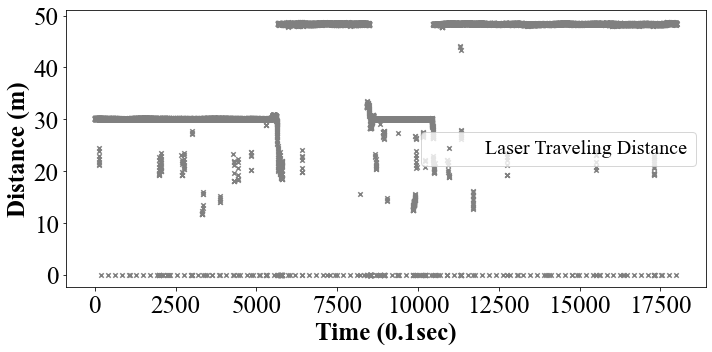

In [84]:
laser_id = 13
azimuth_channel = 539
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
# for i in range(len(thred)):
#     plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
# plt.ylim(0.1,40)
plt.legend(fontsize = '20')
plt.tight_layout()
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\FIG\PixelProcess.tif',dpi = 300)
plt.show()

In [136]:
parking_label.max()

True

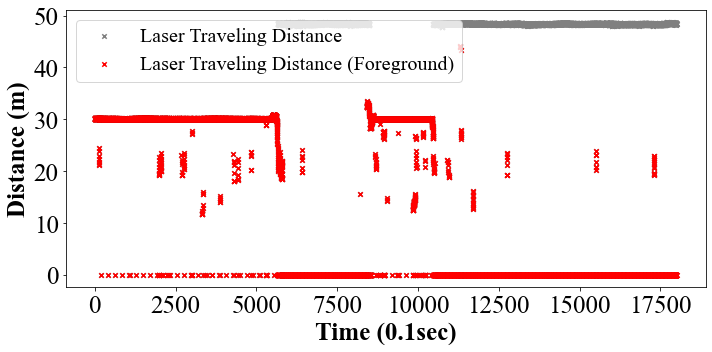

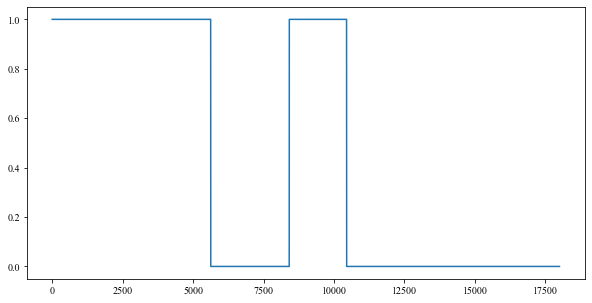

In [134]:
laser_id = 13
azimuth_channel = 539
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')

thred = thred_map[:,laser_id,azimuth_channel]
thred_max = thred.max()
bck_inds = ((np.abs((temp - thred_max)) < 2))
temp[bck_inds] = 0
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance (Foreground)", c = 'r')
time_window = 600
parking_label  = []
for i in range(time_window,len(temp)):
    past_dis = temp[i - time_window:i]
    past_dis = past_dis[past_dis!=0]
    if len(past_dis) == 0:
        parking_label.append(False)
    else:
        if np.abs(temp[i] - np.median(past_dis)) < 0.5:
            parking_label.append(True)
        else:
            parking_label.append(False)
parking_label = time_window*[parking_label[0]] + parking_label

plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
# plt.ylim(0.1,40)
plt.legend(fontsize = '20')
plt.tight_layout()
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\FIG\PixelProcess.tif',dpi = 300)
plt.show()
plt.figure(figsize=(10,5))
parking_label = np.array(parking_label)
counts,appears = count(~parking_label)
for i,a in enumerate(appears):
    c = counts[i]
    if c < time_window:
        parking_label[a:a+c+1] = True
counts,appears = count(parking_label)
for i,a in enumerate(appears):
    c = counts[i]
    if c < time_window:
        parking_label[a:a+c+1] = False
counts,appears = count(parking_label)        
plt.plot(parking_label)

plt.show()

In [127]:
laser_coords_3

array([[ 11, 553],
       [ 11, 554],
       [ 11, 555],
       [ 11, 556],
       [ 11, 557],
       [ 11, 558],
       [ 11, 559],
       [ 11, 560],
       [ 12, 552],
       [ 12, 553],
       [ 12, 554],
       [ 12, 554],
       [ 12, 554],
       [ 12, 556],
       [ 12, 557],
       [ 12, 558],
       [ 12, 559],
       [ 12, 560],
       [ 12, 561],
       [ 13, 552],
       [ 13, 553],
       [ 13, 554],
       [ 13, 555],
       [ 13, 556],
       [ 13, 557],
       [ 13, 558],
       [ 13, 559],
       [ 13, 560],
       [ 13, 561],
       [ 13, 562],
       [ 14, 552],
       [ 14, 553],
       [ 14, 554],
       [ 14, 556],
       [ 14, 557],
       [ 14, 558],
       [ 14, 559],
       [ 14, 560],
       [ 14, 561],
       [ 14, 562],
       [ 14, 563],
       [ 14, 564],
       [ 15, 551],
       [ 15, 552],
       [ 15, 553],
       [ 15, 554],
       [ 15, 555],
       [ 15, 556],
       [ 15, 557],
       [ 15, 558],
       [ 15, 560],
       [ 15, 561],
       [ 15,

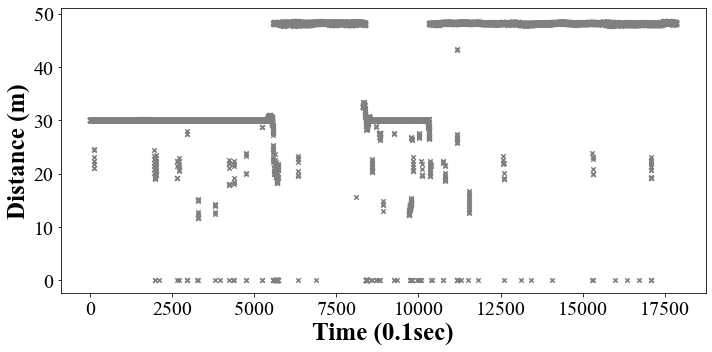

In [19]:
laser_id = 13
azimuth_channel = 538
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
# for i in range(len(thred)):
#     plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
# plt.ylim(19.2,19.27)

plt.show()

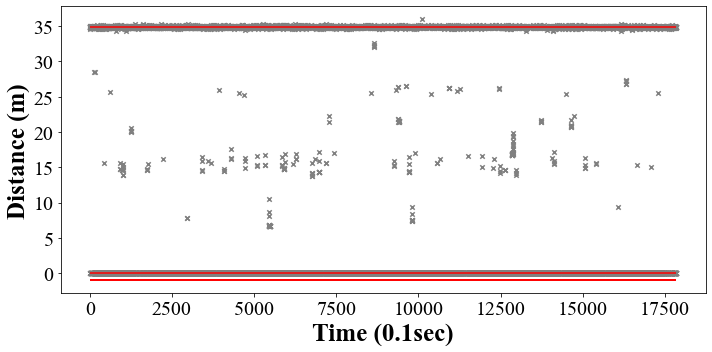

In [17]:
laser_id = 11
azimuth_channel = 1344
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
for i in range(len(thred)):
    plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
# plt.ylim(34.5,36)

plt.show()

In [ ]:

temp = 

In [36]:
aggregated_Labeling_map = []
for i in tqdm(range(aggregated_map.shape[0])):
    Td_map = aggregated_map[i]
    Foreground_map = (~(np.abs(Td_map - thred_map) <= 1.5))&(Td_map > 0)
    Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
    aggregated_Labeling_map.append(Labeling_map)
aggregated_Labeling_map = np.array(aggregated_Labeling_map)
points = []
occupancies = []
row_ind = []
col_ind = []
for i in tqdm(range(32)):
    for j in range(1800):
        foreground_ind = aggregated_Labeling_map[:,i,j] != -1
        if foreground_ind.any(): # foreground
            dis_values = aggregated_map[foreground_ind,i,j]
            labels = dbscan.fit_predict(dis_values.reshape(-1,1))
            unique_labels = np.unique(labels)
            unique_labels = unique_labels[1:]
            if len(unique_labels) >= 1: 
                for l in unique_labels:
                    dis = np.mean(dis_values[labels == l])
                    XYZ = gen_xyz(dis,i,j)
                    points.append(XYZ)
                    occupancy = (labels == l).sum()/len(foreground_ind)
                    occupancies.append(occupancy)
                    row_ind.append(i)
                    col_ind.append(j)
points = np.array(points)
occupancies = np.array(occupancies)
col_ind = np.array(col_ind)
row_ind = np.array(row_ind)
pcd = get_pcd_uncolored(aggregated_map[1354])
plane_model, inliers = pcd.segment_plane(distance_threshold=0.3,
                                         ransac_n=10,
                                         num_iterations=1000)
height = np.abs(plane_model[0] * points[:,0] + plane_model[1] * points[:,1] + plane_model[2] * points[:,2] + plane_model[3]) / (np.sqrt(plane_model[0]**2 + plane_model[1]**2 +plane_model[2]**2))
input_path = r'D:\LiDAR_Data\MidTown\Larue\Calibration'
ref_LLH_path,ref_xyz_path = os.path.join(input_path,'LLE_ref.csv'),os.path.join(input_path,'xyz_ref.csv')
ref_LLH,ref_xyz = np.array(pd.read_csv(ref_LLH_path)),np.array(pd.read_csv(ref_xyz_path))
if len(np.unique(ref_xyz[:,2])) == 1:
    np.random.seed(1)
    offset = np.random.normal(-0.521,3.28,len(ref_LLH))
    ref_xyz[:,2] += offset
    ref_LLH[:,2] += offset * 3.2808
ref_LLH[:,[0,1]] = ref_LLH[:,[0,1]] * np.pi/180
ref_LLH[:,2] = ref_LLH[:,2]/3.2808

T = generate_T(ref_LLH,ref_xyz)
LLH = convert_LLH(points.astype(np.float64),T)
resultGram = pd.DataFrame(np.concatenate([points,LLH,occupancies.reshape(-1,1),height.reshape(-1,1),row_ind.reshape(-1,1),col_ind.reshape(-1,1)],axis =1 ),columns=['X','Y','Z','Longitude','Latitude','Elevation','Occupancy','Height','LaserID','AzimuthID'])
resultGram.to_csv(r'D:\LiDAR_Data\MidTown\Larue\occ.csv',index = False)

 38%|████████████████████████████▉                                                | 12/32 [1:21:34<2:15:58, 407.90s/it]


KeyboardInterrupt: 

In [12]:
temp = aggregated_map[12]
points = []
occupancies = []
row_ind = []
col_ind = []
for i in tqdm(range(32)):
    for j in range(1800):
        dis = temp[i,j]
        XYZ = gen_xyz(dis,i,j)
        points.append(XYZ)
        row_ind.append(i)
        col_ind.append(j)
points = np.array(points)
row_ind = np.array(row_ind)
col_ind = np.array(col_ind)
input_path = r'D:\LiDAR_Data\MidTown\Larue\Calibration'
ref_LLH_path,ref_xyz_path = os.path.join(input_path,'LLE_ref.csv'),os.path.join(input_path,'xyz_ref.csv')
ref_LLH,ref_xyz = np.array(pd.read_csv(ref_LLH_path)),np.array(pd.read_csv(ref_xyz_path))
if len(np.unique(ref_xyz[:,2])) == 1:
    np.random.seed(1)
    offset = np.random.normal(-0.521,3.28,len(ref_LLH))
    ref_xyz[:,2] += offset
    ref_LLH[:,2] += offset * 3.2808
ref_LLH[:,[0,1]] = ref_LLH[:,[0,1]] * np.pi/180
ref_LLH[:,2] = ref_LLH[:,2]/3.2808

T = generate_T(ref_LLH,ref_xyz)
LLH = convert_LLH(points.astype(np.float64),T)
resultGram = pd.DataFrame(np.concatenate([points,LLH,row_ind.reshape(-1,1),col_ind.reshape(-1,1)],axis =1 ),columns=['X','Y','Z','Longitude','Latitude','Elevation','LaserID','AzimuthID'])
resultGram.to_csv(r'D:\LiDAR_Data\MidTown\Larue\reference.csv',index = False)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 93.06it/s]


In [56]:
temp = aggregated_map[12].copy()
label_map = np.zeros_like(temp)
label_map[11:12,1340:1343] = 1
pcd = get_pcd_colored(temp,label_map.astype(int))
draw(pcd,height=1000,width=1000)

WebVisualizer(window_uid='window_17')

In [32]:
thred_map = thred_map.max(axis = 0)

In [35]:
Td_map = aggregated_map[2]
Foreground_map = (~(np.abs(Td_map - thred_map) <= 1))&(Td_map > 0)
pcd = get_pcd_colored(Td_map,Foreground_map.astype('int'))
draw(pcd)

WebVisualizer(window_uid='window_4')

0.0
1344


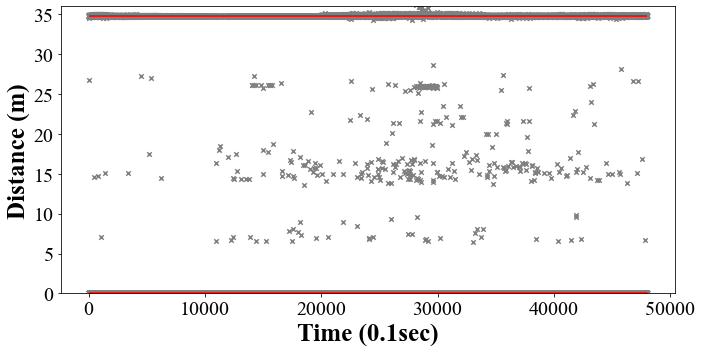

In [64]:
laser_id = 11
azimuth_channel = 1344
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_maps[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
for i in range(len(thred)):
    plt.hlines(thred[i],0,aggregated_maps.shape[0],color = 'r')
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
plt.ylim(0,36)

# plt.xlim(2000,2400)
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\parameterdefinition.tif', dpi = 600)
plt.show()

# create dataset

In [1]:
import matplotlib.pyplot as plt
from matplotlib import image
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd
import cv2
import os
from BfTableGenerator import TDmapLoader
from tqdm import tqdm
from Utils import *
from open3d.web_visualizer import draw
from joblib import Parallel, delayed
from VisulizerTools import *
from DDBSCAN import Raster_DBSCAN
from sklearn.cluster import DBSCAN
import time
plt.rcParams["font.family"] = "Times New Roman"
from GeoRefTool import *
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.data import stereo_motorcycle, vortex
from skimage.transform import warp
from skimage.registration import optical_flow_tvl1, optical_flow_ilk


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
aggregated_map = []
Inten_maps = []
pcap_path = r'D:\LiDAR_Data\MidTown\Larue\PaperPcaps\2022-1-22-13-0-0.pcap'
end_frame = 18000
lidar_reader = TDmapLoader(pcap_path)
frame_gen = lidar_reader.frame_gen()
for i in tqdm(range(end_frame)):
    Frame = next(frame_gen)
    if Frame is None:
        break 
    Td_map,Int_map = Frame
    aggregated_map.append(Td_map)
    Inten_maps.append(Int_map)
aggregated_map = np.array(aggregated_map)
Inten_maps = np.array(Inten_maps)

100%|████████████████████████████████████████████████████████████████████████████| 18000/18000 [11:33<00:00, 25.96it/s]


In [4]:
for i in range(len(aggregated_map)):
    a = np.random.rand()
    if a < 0.3:
        pcd = get_pcd_uncolored(aggregated_map[i])
        op3.io.write_point_cloud(r'D:\LiDAR_Data\MidTown\Larue\test\pcds\{}'.format(f"{i:06d}.pcd"),pcd)

In [3]:
pcd = get_pcd_uncolored(aggregated_map[-1])
points = np.asarray(pcd.points)

In [3]:
pcd = get_pcd_uncolored(aggregated_map[14600])
draw(pcd,width=1000,height=1000)

WebVisualizer(window_uid='window_0')

In [51]:
list_dir = os.listdir(r'D:\LiDAR_Data\MidTown\Larue\test\2022-1-22-13-0-0')
valid_points = [pd.read_csv(os.path.join(r'D:\LiDAR_Data\MidTown\Larue\test\2022-1-22-13-0-0',list_dir[i])) for i in range(len(list_dir)) ]

In [84]:
sample_point = np.array(valid_points[0].loc[:,['Points_m_XYZ:0','Points_m_XYZ:1','Points_m_XYZ:2']])

In [7]:
pcd = get_pcd_uncolored(aggregated_map[0])
points = np.asarray(pcd.points)

In [8]:
points = points[(~((points == 0).all(axis = 1)))]

In [9]:
len(points)

42080

In [63]:
def read_firing_data(data):
    block_id = data[0] + data[1]*256
    azimuth = (data[2] + data[3] * 256) / 100 # degree
    firings = data[4:].reshape(32, 3) 
    distances = firings[:, 0] + firings[:, 1] * 256 # mm 
    intensities = firings[:, 2] # 0-255
    return distances, intensities, azimuth #(1,0)

In [64]:
def read_uint32(data, idx):
    return data[idx] + data[idx+1]*256 + data[idx+2]*256*256 + data[idx+3]*256*256*256

In [65]:
def parse_one_packet(data):
    data = np.frombuffer(data, dtype=np.uint8).astype(np.uint32)
    blocks = data[0:1200].reshape(12, 100)
    Timestamp = read_uint32(data[1200:1204],0)
    distances = []#12*32
    intensities = []#12*32
    azimuth_per_block = [] #(12,0)
    # iteratie through each block
    for i, blk in enumerate(blocks):
        dists, intens, angles = read_firing_data(blk)
        distances.append(dists) #12*32
        intensities.append(intens) #12*32
        azimuth_per_block.append(angles)

    azimuth_per_block = np.array(azimuth_per_block).T
    distances = 4/1000*np.array(distances).T # 32,12
    intensities = np.array(intensities).T # 32,12

    return distances,intensities, azimuth_per_block, Timestamp # 12*0

In [67]:
fpcap = open(r'D:\LiDAR_Data\MidTown\Larue\PaperPcaps\2022-1-22-13-0-0.pcap', 'rb')
lidar_reader = dpkt.pcap.Reader(fpcap)

In [68]:
count = 0
packets = []
while count < 5000:
    ts,buf = next(lidar_reader)
    eth = dpkt.ethernet.Ethernet(buf)
    if eth.type == 2048:
        if type(eth.data.data) == dpkt.udp.UDP:
            data = eth.data.data.data
            packet_status = eth.data.data.sport
            if packet_status == 2368:
                count +=1
                if len(data) != 1206:
                    
                    continue
                """
                distances : (32,12)
                intensities : (32,12)
                azimuth_per_block : (12,0)
                """
                distances,intensities,azimuth_per_block,Timestamp = parse_one_packet(data)
                packets.append((distances,intensities,azimuth_per_block,Timestamp))

## Parking Analysis

In [36]:
Parking_coord_1 = pd.read_csv(r'D:\LiDAR_Data\MidTown\Larue\Parking1.csv')
Parking_coord_2 = pd.read_csv(r'D:\LiDAR_Data\MidTown\Larue\Parking2.csv')
Parking_coord_3 = pd.read_csv(r'D:\LiDAR_Data\MidTown\Larue\Parking3.csv')

In [71]:
laser_coords_1 = np.array(Parking_coord_1.loc[:,['LaserID','AzimuthID']]).astype('int')
laser_coords_2 = np.array(Parking_coord_2.loc[:,['LaserID','AzimuthID']]).astype('int')
laser_coords_3 = np.array(Parking_coord_3.loc[:,['LaserID','AzimuthID']]).astype('int')


In [55]:
f_path = r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\DATA\Larue22'
parking_event_list = os.listdir(f_path)
time = []
for p in parking_event_list:
    t = p.split('.')[0]
    Year,Month,Day,Hour,Minitue,Second = np.array(t.split('-')).astype('int')
    time.append(pd.Timestamp(Year,Month,Day,Hour,Minitue,Second))
ts_ind = pd.Series(time).argsort().values
ts = pd.Series(time).sort_values()
parking_event_list = np.array(parking_event_list)[pd.Series(time).argsort().values]

In [61]:
test = pd.read_csv(os.path.join(f_path,parking_event_list[4]))

In [78]:
test_table

,X,Y,Z,Longitude,Latitude,Elevation,Height,Occupancy,LaserID,AzimuthID
3051,32.301941,-12.012984,0.200302,-119.808016,39.516684,1318.012722,0.176143,17652.0,21.0,552.0


In [77]:
for c in laser_coords_3:
    test_table = test.loc[(test.LaserID == c[0])&(test.AzimuthID == c[1])]
    start = test_table
    if len(test_table) >0 :
        print(test_table)

             X          Y         Z   Longitude   Latitude   Elevation  \
840  32.298404 -12.140172 -1.808312 -119.807971  39.516712  1318.01251   

       Height  Occupancy  LaserID  AzimuthID  
840  2.185598    12781.0     11.0      553.0  
              X          Y         Z  Longitude   Latitude    Elevation  \
1000  31.994108 -11.898502 -1.590062 -119.80798  39.516708  1318.012528   

        Height  Occupancy  LaserID  AzimuthID  
1000  1.962816    14931.0     12.0      552.0  
              X          Y         Z  Longitude   Latitude    Elevation  \
1001  41.143019 -16.456033 -2.064121 -119.80787  39.516763  1318.012626   

        Height  Occupancy  LaserID  AzimuthID  
1001  2.552031    12947.0     12.0      559.0  
              X          Y         Z   Longitude   Latitude    Elevation  \
1163  31.665110 -11.776149 -1.376395 -119.807987  39.516703  1318.012546   
1164  32.062188 -11.923821 -1.393654 -119.807983  39.516706  1318.012550   

        Height  Occupancy  LaserID